# 캐글 경진대회 따라하기 - House Price Prediction(집값 예측)
![img](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

캐글코리아: [링크](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)



---
차례
- **대회의 시작: 참가 규칙과 데이터, 평가 기준 살펴보기**
- **Baseline은 여기 있으니까!**
- 랭킹을 올리고 싶다면? 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝
- 프로젝트: This is your playground! Leaderboard를 정복

---
필요 라이브러리 : xgboost, lightgbm, missingno
```
$ conda list | grep xgboost
$ conda list | grep lightgbm
$ conda list | grep missingno
$ pip list | grep scikit-learn
```

# (1) 참가 규칙, 평가 기준 살펴보기
집값을 예측하는 문제로 평가방식는 RMSE(Root Mean Squared Error)이 이다
- 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근

$$ \sqrt{\frac{\sum{(Y_t - Y_{pr})^2}}{N}} $$

Rules

1. 한 참가자당 한 개의 캐글 계정을 가지고 참여하셔야 합니다.
2. 본 대회에서는 외부 데이터의 사용을 금합니다.
3. Team merger
 - 본 대회는 team merger가 허용되지 않습니다.
4. 제출 횟수
- 하루 최대 제출 횟수만큼인 5번 제출할 수 있습니다.

5. Competition Timeline(마감기한)
 - Start Date: 2019/03/11 00:00 AM UTC Time
 - Entry Deadline: None
 - End Date: 2019/04/22 23:59 PM UTC

# (2) 데이터 살펴보기

### File descriptions
- train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.
- test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.
- sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.

### Data fields

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

---

# (3) Baseline 모델 
Baseline이란?
- 기본적으로 문제 해결을 시작할 때 쉽게 사용해볼 수 있는 샘플 

커널(Kernel)이란?
- 캐글에서 커널은 우리가 쓰는 주피터 노트북 형태의 파일이 캐글 서버에서 실행될 때 그 프로그램을 일컬음

다른 사람의 커널을 ipynb 파일사용하기
- 다른 사람의 커널화면상단의 [Copy and Edit] 메뉴또는 ['''] 메뉴의 Download를 통해 사용가능

### 3-1. Baseline 셋팅하기
- 데이터파일을 노트북이 있는 같은 폴더로 이동
```
├── 2019-ml-month-2nd-baseline.ipynb 
└── data
    ├── sample_submission.csv       
    ├── test.csv       
    └── train.csv     
```
- 시각화를 위한 설정
```
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
```

### 3-2. Baseline 라이브러리, 데이터 가져오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


캐글 코드 경로 : ../input 이라는 디렉토리에 위치
```
train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')
```
자기 커널 위치에 맞게 변경하기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/project/exp05_Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/project/exp05_Kaggle/data/train.csv
/aiffel/aiffel/project/exp05_Kaggle/data/test.csv


### 3-3.  Baseline 데이터 이해하기

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim: {}'.format(data.shape))
print('sub data dim: {}'.format(sub.shape))

train data dim: (15035, 21)
sub data dim: (6468, 20)


학습 데이터는 약 1만 5천 개, 테스트 데이터는 약 6천 개로 구성되어있다.
train data에서 price컬럼을 우리가 예측해야하므로 y라는 변수에 따로 관리하자

In [4]:
y = data['price']
del data['price'] #drop 함수도 가능
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

### EDA
데이터를 탐색하기위하여 train, sub데이터를 합쳐보자

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [6]:
#결측치 확인
data.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

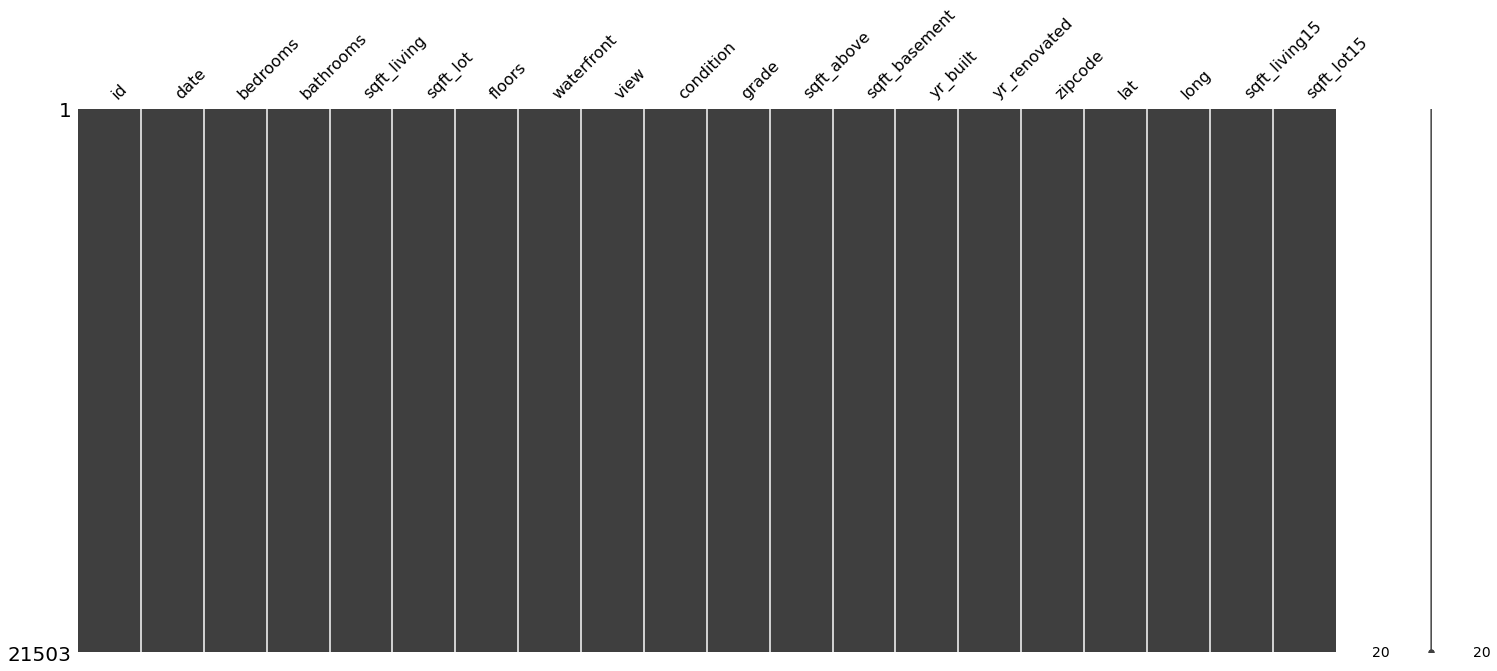

In [7]:
# 결측치 missingno 라이브러리의 matrix 함수로 시각화
msno.matrix(data)

In [10]:
#결측치 컬럼으로 확인
null_check = pd.isnull(data['id'])
null_check

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool

In [11]:
#결측치인 데이터만 출력
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [ ]:
#결측치 개수 확인

In [12]:
print('{}:{}'.format('id',len(null_data.values)))

id:0


id 컬럼 외에도 모든 컬럼의 결측치 확인해보자

In [ ]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

### 필요없는 컬럼 제거
- id 컬럼 : 집값예측과 무관, 제출을 위해 일때 sub_id로 따로 저장해주고 지우기

In [ ]:
sub_id = data['id'][train_len:] #테스트 셋부분의 id만 설정
del data['id']
print(data.columns, len(data.columns))

### 인덱싱의 장점
- 데이터프레임을 그대로 사용할 수 있고 속도면에서도 월등히 빠름

### 복잡한 로직은 lambda와 apply를 활용해 간단하게
- date컬럼의 데이터중 20141013T000000 -> 의미있는 부분만 잘라내보자

In [16]:
data['date'] = data['date'].apply(lambda x:str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 변경

### 각 컬럼별 데이터가 분포 확인
-  너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업이 필요

- 시본의 kdeplot 으로 이산 데이터를 확인해보자


In [28]:
data.columns


Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

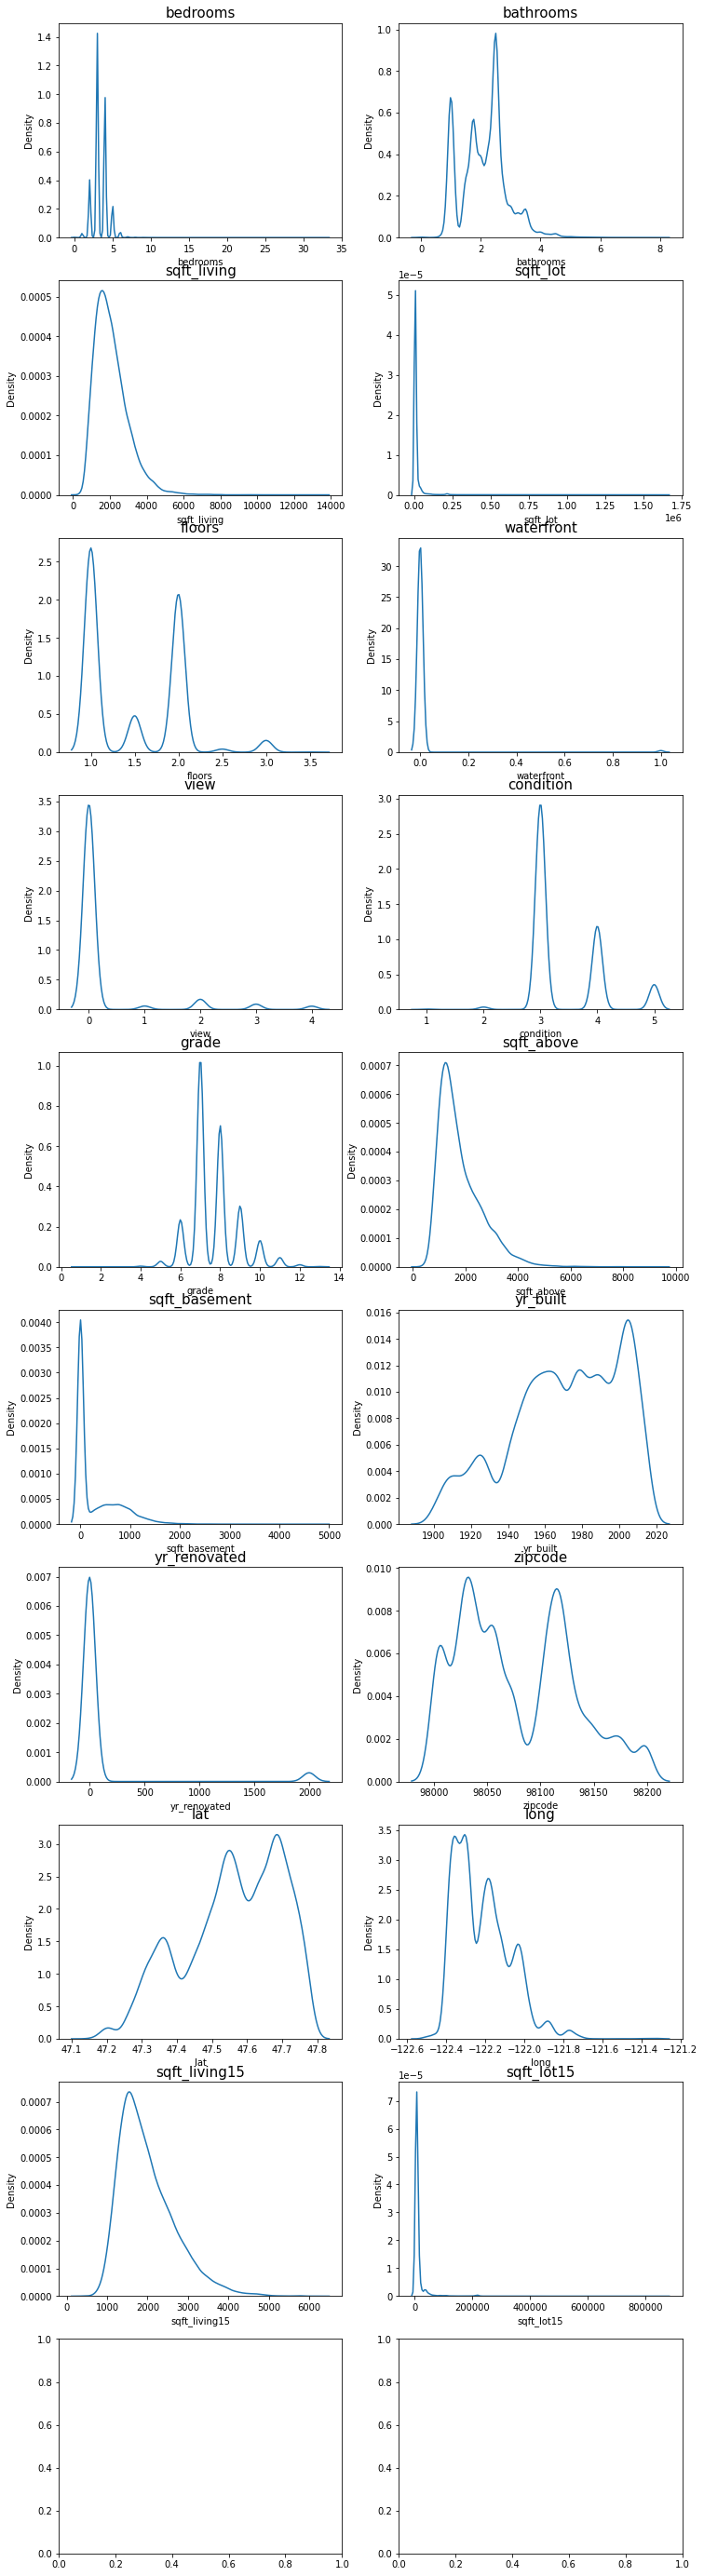

In [27]:
#총 19개 컬럼 - 10행 2열으로 출력
fig, ax = plt.subplots(10,2, figsize=(12,50)) 

# id 변수는 제외하고 분포를 확인합니다. 
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break


데이터의 분포에서 한쪽으로 치우친경향을 보이는 컬럼을 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포로 변경 시키자
- bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15
- numpy.log1p() 함수 : 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수

In [29]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)



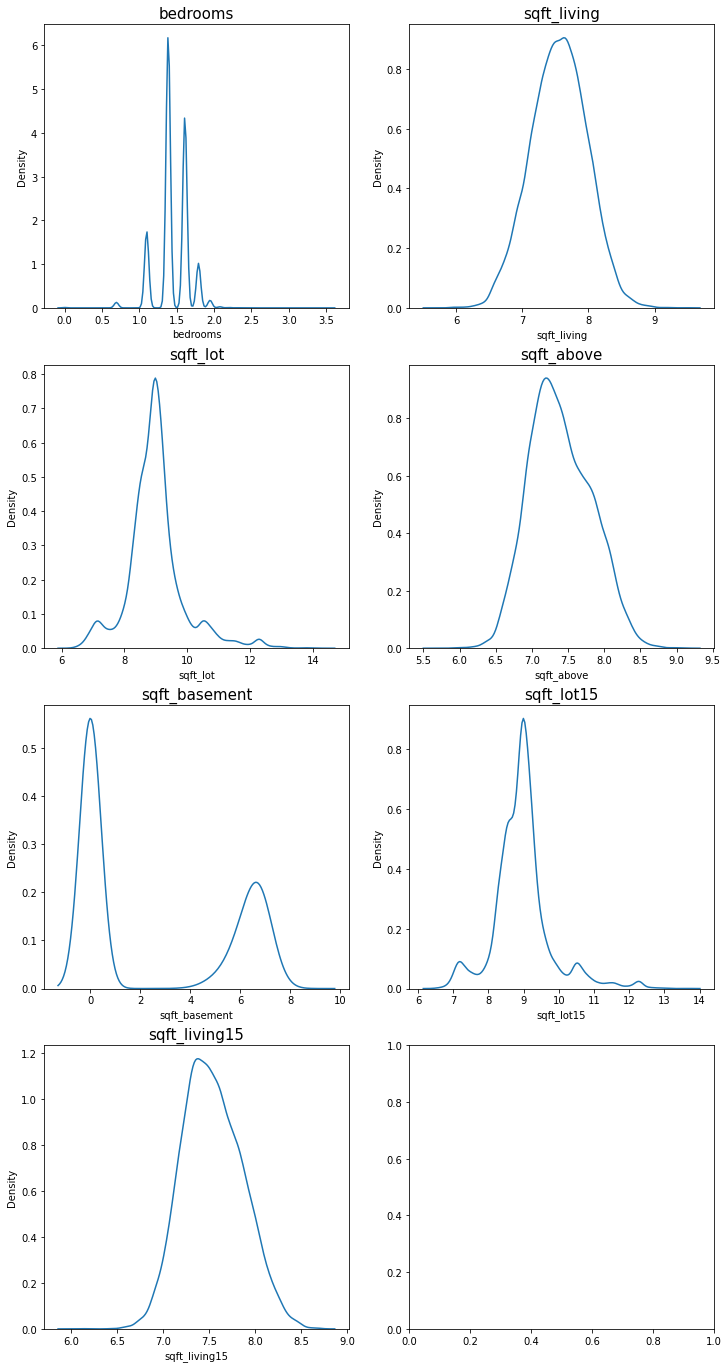

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 로그변환은 어떻게  분포의 치우침을 바로잡아줄수있는가?
로그 함수의 특징
- 0<x<1 범위에서는 기울기가 매우 가파름. x의 구간은 (0, 1)로 매우 짧은 반면, yy의 구간은 (−∞,0)으로 매우 크다.
- x>1 범위에서는 기울기가 매우 완만함. x의 구간은 (1, ∞)로 매우 넓은 반면, yy의 구간은 x의 변화량이 큰것보다 적게변한다.
 - 0<x<1 범위 : x값에 대한 y값을 넓게 펼쳐줌
   -  0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 된다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징
 - x>1 범위 : x값에 대한 y값을 모아줌
   -  xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다. 이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징


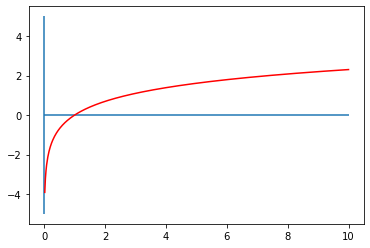

In [32]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx) #자연로그

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='red')


타겟데이터인 price의 분포를 로그변환을 해보면서 다시 정리해보자

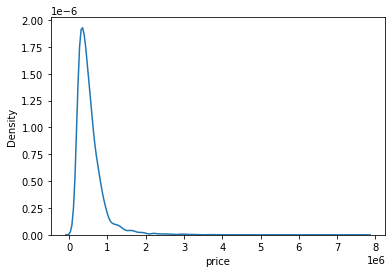

In [39]:
sns.kdeplot(y)
plt.show()

위 그래프를 자연로그 변환하면 x>1 범위 의x값에 대한 y값을 모아줌, x<1보다  작은 x값에 대한 y값은 넓게 퍼질것이다.

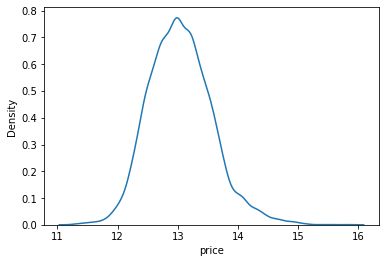

In [40]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

데이터의 전처리를 마무리했다. 다시 훈련셋과 테스트셋으로 나누어 학습을 해보자

In [41]:
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]
print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 3-4. Baseline 모델 설계

블렌딩(blending) 기법 
- [앙상블 기법](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)이라고도 불림
- 서로 다른 알고리즘을 가진 분류기가 같은 데이터셋을 기반으로 학습되고 결합
 - cf. Bagging : 같은 알고리즘 유형의 모델들이 이지만 데이터 샘플링을 다르게 하여 학습
- 여러 가지 모델을 함께 사용해서 결과를 섞어 일반적인 예측이 가능하도록함
- 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법
- 대부분의 정형 데이터 분류 시에는 앙상블이 뛰어난 성능을 나타냄

앙상블 기법
- 보팅(Voting) : 분류 에서 사용
- 에버리징(Averaging) : 회귀 에서 사용

### Voting 진행과정
- base model 만들기,  Linear Regression, KNN, SVM 등 여러 머신러닝 모델을 사용
- Majority Voting (Hard Voting) : 각 모델은 test 데이터셋(또는 인스턴스)의 결과를 예측한후 예측값들의 다수결로 예측값을 정함.
- Weighted Voting (Soft Voting) : 각 모델은 test 데이터셋(또는 인스턴스)의 결과값의 확률을 평균으로 하여 평균이 큰값을 예측값으로 함
![이](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcvYig2%2FbtqKsojGyfl%2FiKazMxfc8GKeWa1OHYjHH0%2Fimg.png)
 출처: 파이썬 머신러닝 완벽 가이드

이렇게 앙상블 모델이 강력한 이유는?
- 앙상블은 강력한 개별 모델 하나보다 약한 여러 개의 모델의 결과를 합치는 것이 낫다는 기본 전제로부터 시작되었다. 왜 그럴까? : [참고](https://jamm-notnull.tistory.com/16)

사례로 각 성능이 70%(0.7)인 다섯 개의 분류기가 있다고 가정합니다.
이 때 이 다섯 개의 모델이 예측한 결과에 다수결 투표를 진행하여 최종 결과를 결정한다면 예상 정확도는 얼마일까요?
(힌트: 고등학생 때 배웠던 순열과 조합의 독립시행의 확률을 떠올려보세요!)
```
다섯 개의 분류기가 전부 다 틀릴 확률은 0.3^5 = 0.0024 입니다.
하나의 분류기만 맞고, 네 개의 분류기가 틀릴 확률은 5C_1 × 0.3^4 × 0.7 = 0.0284 입니다.
두 개의 분류기만 맞고, 세 개의 분류기가 틀릴 확률은 5C_2 × 0.3^3 × 0.7^2 = 0.1323 입니다.
세 개의 분류기만 맞고, 두 개의 분류기가 틀릴 확률은 5C_3 × 0.3^2 × 0.7^3 = 0.3087 입니다.
네 개의 분류기가 맞고, 한 개의 분류기가 틀릴 확률은 5C_4 × 0.3 × 0.7^4 = 0.3602 입니다.
다섯 개의 분류기가 모두 맞을 확률은 0.7^5 = 0.1681 입니다.
(확인 : 위의 여섯가지의 확률의 총합은 0.0024 + 0.0284 + 0.1323 + 0.3087 + 0.3602 + 0.1681 = 1 이 맞습니다!)

위의 여섯 가지 중, 다수결을 통해 최종 예측을 결정을 할 때 옳은 예측을 하려면 최소 세 개 이상의 분류기가 맞아야 합니다.

즉, 세 개 이상의 분류기가 맞을 확률의 총 합은 0.3087 + 0.3602 + 0.1681 =0.837, 즉 83.7%입니다.
이는 개별 분류기의 성능인 70%보다 훨씬 높은 성능을 보입니다!
```

집값 예측문제는 회귀문제이므로 Average Blending 기법을 적용해 보겠다.
모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용할 것이다.

In [42]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가해보자. 각각을 결과가 나오는데 시간이 소요되므로 모델 3개의 결과가 나올때까지 잠깐 기다려보자

In [43]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")


In [44]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


cross_val_score() 함수는 회귀모델을 전달할 경우 $R^2 $  점수를 반환한다.
$R^2 $  값은 1에 가까울수록 모델이 잘 학습되었다고 볼수 있다. 각모델이 1에 가까운 값을 출력한걸보니 괜찮은 성능인것 같다. 

여기에 AveragingBlending을 적용해보자

In [45]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

이제 이 예측 결과를 캐글에 제출하기 위해 submission.csv파일에 붙여주면된다

### 3-5. Baseline 모델로 캐글에 첫 결과 제출하기

In [46]:
data_dir = os.getenv('HOME')+'/aiffel/project/exp05_Kaggle/data'
sub_path = join(data_dir,  'sample_submission.csv')
submission = pd.read_csv(sub_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


id와 price의 두 가지 열로 구성되어있다. 이와 같은 구성으로 DataFrame을 만들어준다.

In [48]:
res = pd.DataFrame({
    'id':sub_id,
    'price':y_pred 
})

res.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [50]:
my_submission_path = join(data_dir, 'submission.csv')
res.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/project/exp05_Kaggle/data/submission.csv


ubmission.csv 파일을 대회 페이지의 Late Submission버튼을 눌러 제출한다.
점수를 확인해보니 120031.23722 점 이다.
여기까지가 캐글코리아에서 제공한 Baseline 모델이였다.

---
# Reference

- 데이터 사이언스 스쿨 : [링크](https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1)
- apply, lambda 활용 : [링크](https://data-newbie.tistory.com/207)
- 앙상블이란? : [링크](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)
- 앙상블이 강력한 이유 : [링크](https://jamm-notnull.tistory.com/16)
- 회귀모델 성능지표 결정계수 : [링크](https://ltlkodae.tistory.com/19)